In [1]:
# define and move to dataset directory
import os
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from datetime import datetime
import itertools 
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
trainPath = 'C:\\Users\\sazid\\Desktop\\jour_data\\all_three\\train'
valPath = 'C:\\Users\\sazid\\Desktop\\jour_data\\all_three\\valid'
testPath = 'C:\\Users\\sazid\\Desktop\\jour_data\\all_three\\test'

In [3]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
testAug=ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
testAug.mean = mean

In [4]:
# initialize the training generator
batch_size = 32
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)
# initialize the testing generator
testGen = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)

Found 5006 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [5]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
#VGG16 = keras.applications.vgg16
from keras.layers import Input
from keras.applications import VGG16
from keras.models import Model
from keras.optimizers import SGD

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model

# Freeze four convolution blocks
for layer in baseModel.layers [:11]:
    layer.trainable = False
    
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

model.summary() 

# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable

totalTrain=5006
totalVal=1000
print("compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["acc"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("training head...")
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=valGen,
    validation_steps=totalVal // batch_size,
    epochs=100)

compiling model...
training head...
Epoch 1/100
156/156 [==============================] - 267s 2s/step - loss: 3.0218 - acc: 0.3028 - val_loss: 1.2252 - val_acc: 0.4415
Epoch 2/100
156/156 [==============================] - 214s 1s/step - loss: 1.2349 - acc: 0.4223 - val_loss: 1.1287 - val_acc: 0.4536
Epoch 3/100
156/156 [==============================] - 209s 1s/step - loss: 1.1736 - acc: 0.4265 - val_loss: 1.1040 - val_acc: 0.4486
Epoch 4/100
156/156 [==============================] - 209s 1s/step - loss: 1.1343 - acc: 0.4435 - val_loss: 1.1014 - val_acc: 0.4546
Epoch 5/100
156/156 [==============================] - 212s 1s/step - loss: 1.0863 - acc: 0.4741 - val_loss: 1.1284 - val_acc: 0.4325
Epoch 6/100
156/156 [==============================] - 219s 1s/step - loss: 1.0517 - acc: 0.4894 - val_loss: 1.1041 - val_acc: 0.4899
Epoch 7/100
156/156 [==============================] - 220s 1s/step - loss: 1.0074 - acc: 0.5212 - val_loss: 1.0571 - val_acc: 0.5454
Epoch 8/100
156/156 [=====

In [7]:
model.save("multi_vgg16.h5")

In [8]:
target_names = []
for key in trainGen.class_indices:
    target_names.append(key)
    
print(target_names)


['background', 'lizard', 'snake', 'toad']


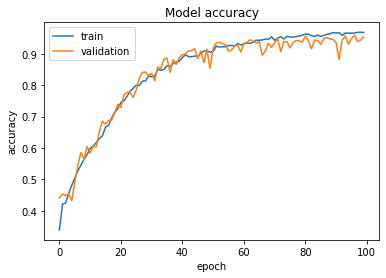

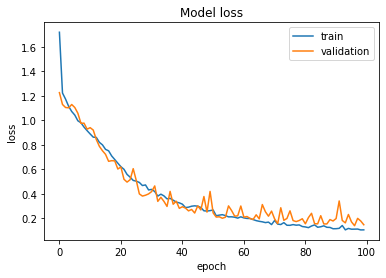

In [9]:
############################################
#Plot the Graph

acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')
plt.show()

In [11]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("evaluating after fine-tuning network head...")

totalTest=400
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

evaluating after fine-tuning network head...
              precision    recall  f1-score   support

  background       0.88      0.74      0.80       100
      lizard       0.78      0.86      0.82       100
       snake       0.84      0.96      0.90       100
        toad       0.99      0.91      0.95       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



Confusion matrix, without normalization


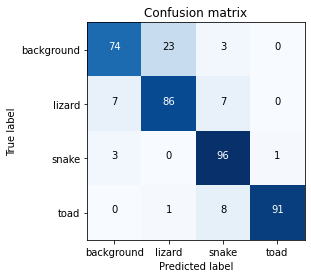

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix of snake Vs background', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#thresh = cm.max() / 2.
#Matplotlib’s matshow
cm = confusion_matrix(testGen.classes, predIdxs)

plt.figure(3)
plot_confusion_matrix(cm, target_names, title='Confusion matrix')
#print(cm)
plt.savefig('lizard_VGG16.png')
plt.show()